# Committor cross validation
This notebook will show a quick way to asses if a training configuration gives self-consistent results.
It assumes you have two trained RCModels and the corresponding OPS storages.
By plotting the predictions of one model for points from its own training process against the prediction of the other model for those points as a scatter plot we can asses if the two models predict the same. If the points deviate from the diagonal this can have two different reasons:
1. The models overfit to their respective training points and do not generalize well.
2. The models have sampled two different reaction channels.

To exclude #2 one could either try to train a third model on the combination of training points and repeat the test or have a look at the TP ensembles in some suitable projection if that is at hand.

In [1]:
import arcd
import os
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger

Using TensorFlow backend.


In [2]:
# change to the working directory of your choice
wdir = '/homeloc/scratch/hejung/arcd_scratch/LiCl/'
#wdir = None
cur_dir = os.path.abspath(os.getcwd())
if wdir is not None:
    os.chdir(wdir)

In [3]:
storageI = paths.Storage('LiCl_snn.nc', 'a')

In [4]:
samplerI = storageI.pathsimulators[0]
samplerI.restart_at_step(storageI.steps[-1], storageI)
trainhookI = arcd.ops.TrainingHook(None, None, 100)
samplerI.attach_hook(trainhookI)

Restoring RCModelSelector without model.If used together with arcd.TrainingHook you can ignore this warning, otherwise please take care of resetting the model yourself.


In [5]:
samplerI.run(1)

Working on Monte Carlo cycle number 5001
Starting simulation...
Working on first step
DONE! Completed 5001 Monte Carlo cycles.


In [6]:
storageII = paths.Storage('LiCl_snnII.nc', 'a')

In [7]:
samplerII = storageII.pathsimulators[0]
samplerII.restart_at_step(storageII.steps[-1], storageII)
trainhookII = arcd.ops.TrainingHook(None, None, 100)
samplerII.attach_hook(trainhookII)

Restoring RCModelSelector without model.If used together with arcd.TrainingHook you can ignore this warning, otherwise please take care of resetting the model yourself.


In [8]:
samplerII.run(1)

Working on Monte Carlo cycle number 5001
Starting simulation...
Working on first step
DONE! Completed 5001 Monte Carlo cycles.


In [34]:
pred_A = trainhookI.model(trainhookI.trainset.descriptors, use_transform=False)
pred_B = trainhookII.model(trainhookI.trainset.descriptors, use_transform=False)

In [35]:
pred_A = pred_A.flatten()
pred_B = pred_B.flatten()

In [36]:
pred_A_ = trainhookII.model(trainhookII.trainset.descriptors, use_transform=False).flatten()
pred_B_ = trainhookI.model(trainhookII.trainset.descriptors, use_transform=False).flatten()

In [18]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

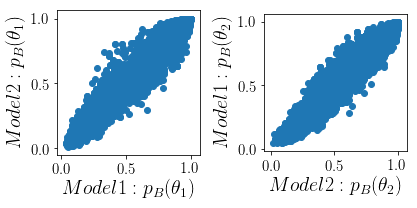

In [41]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
ax.scatter(pred_A, pred_B)
ax.set_aspect('equal')
ax.set_xlabel(r'$Model 1: p_B( \theta_1)$', size=20)
ax.set_ylabel(r'$Model 2: p_B( \theta_1)$', size=20)
ax.tick_params(labelsize=15)

ax = axs[1]
ax.scatter(pred_A_, pred_B_)
ax.set_aspect('equal')
ax.set_xlabel(r'$Model 2: p_B( \theta_2)$', size=20)
ax.set_ylabel(r'$Model 1: p_B( \theta_2)$', size=20)
ax.tick_params(labelsize=15)

fig.tight_layout()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 2)

ax = axs[0]
im, xses, yses, mesh = ax.hist2d(pred_A, pred_B, bins=20, cmin=0, cmax=100)
#ax.tricontour(triang)
ax.set_aspect('equal')
ax.set_xlabel(r'$Model 1: p_B( \theta_1)$', size=20)
ax.set_ylabel(r'$Model 2: p_B( \theta_1)$', size=20)
ax.tick_params(labelsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
fig.colorbar(mesh, cax=cax, orientation='vertical')


ax = axs[1]
im, xses, yses, mesh = ax.hist2d(pred_A_, pred_B_, bins=20, cmin=0, cmax=100)
ax.set_aspect('equal')
ax.set_xlabel(r'$Model 2: p_B( \theta_2)$', size=20)
ax.set_ylabel(r'$Model 1: p_B( \theta_2)$', size=20)
ax.tick_params(labelsize=15)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
fig.colorbar(mesh, cax=cax, orientation='vertical')

fig.tight_layout()

In [42]:
storageI.sync_all()
storageI.close()

In [43]:
storageII.sync_all()
storageII.close()